In [378]:
import geopandas as gpd
import pandas as pd
import shapely
import shapely
from fiona.crs import from_epsg
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shapely.geometry as geom
import seaborn as sns
import pyproj
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from os import listdir
import ast
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1 Combining data sources

## 1.1 311 Complaints in 2016 

In [379]:
df = pd.read_csv('2016_dep_noise.csv')
df['lonlat']=list(zip(df['Longitude'],df['Latitude']))
df['geometry']=df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [380]:
df = gpd.GeoDataFrame(df)

In [381]:
df.crs = from_epsg(4326)
df = df.to_crs(epsg=2263)

In [382]:
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lonlat', 'geometry'],
      dtype='object')

## 1.2 New York Zoning Districts

Here we obtain the zoning districts in the city which we assign to each complaint type.

In [383]:
nyzd = gpd.GeoDataFrame.from_file('nyzd_2016.shp')

In [384]:
nyzd.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [385]:
nyzd.head()

,OBJECTID,ZONEDIST,Shape_Leng,Shape_Area,geometry
0,1,R5,1862.207446,1.943711e+05,"POLYGON ((960088.7548217773 175295.9550170898,..."
1,2,R5,19208.305164,2.767667e+06,"POLYGON ((960059.2919921875 174171.1077880859,..."
2,3,R6,2935.376415,5.333286e+05,"POLYGON ((961651.7064208984 174650.6450195312,..."
3,4,R4,3246.982638,5.797014e+05,"POLYGON ((961651.7064208984 174650.6450195312,..."
4,5,M1-1,1797.546542,1.966755e+05,"POLYGON ((960152.7944335938 174247.2684326172,..."


In [386]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,lonlat,geometry
0,34500485,10/09/2016 07:25:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,90 GOLD STREET,...,NaN,NaN,NaN,NaN,NaN,40.710083,-74.004332,"(40.71008329261251, -74.00433200407059)","(-74.0043320041, 40.7100832926)",POINT (983049.0000007071 197979.014400992)
1,34618125,10/25/2016 09:05:00 PM,10/29/2016 12:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)",POINT (nan nan)
2,34403555,09/25/2016 12:35:00 AM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10463.0,2475 PALISADE AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.880502,-73.922381,"(40.880502135696986, -73.92238094836378)","(-73.9223809484, 40.8805021357)",POINT (1005713.999987205 260078.0144404332)
3,32375355,01/09/2016 11:34:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,40.699659,-73.995690,"(40.699658677488266, -73.99569031190914)","(-73.9956903119, 40.6996586775)",POINT (985444.9999992915 194181.0143985467)
4,32405483,01/13/2016 12:51:00 PM,01/18/2016 08:10:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11229.0,1720 EAST 14 STREET,...,NaN,NaN,NaN,NaN,NaN,40.607419,-73.958987,"(40.607418548173825, -73.95898667787446)","(-73.9589866779, 40.6074185482)",POINT (995637.9999932736 160578.0143765831)


In [387]:
nyzd = nyzd.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


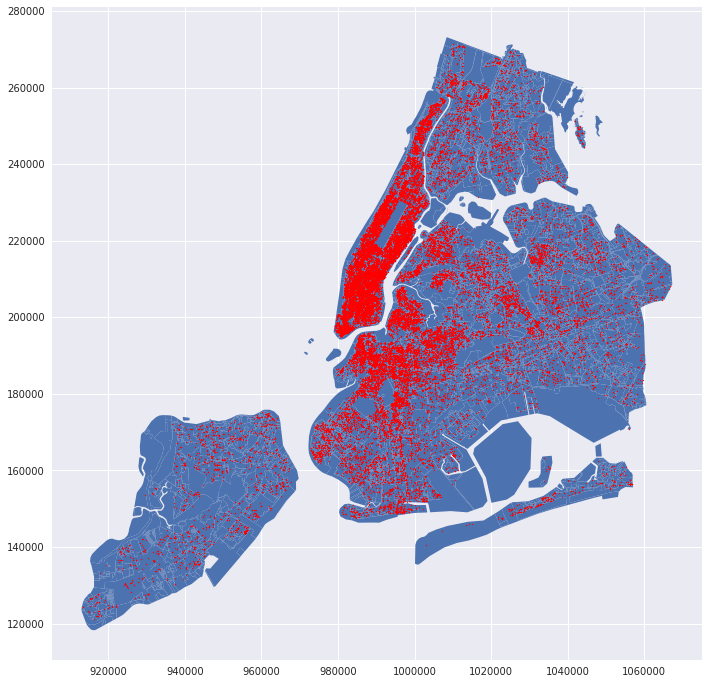

In [388]:
base = nyzd.plot(figsize=(12,12))
#base.axis('off')
df.plot(ax=base,color='red',markersize=1)

This plot just gives us visual confirmation that the complaints and the zoning districts are on same coordinates so that we wont lose any data in the spatial join.

In [389]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,lonlat,geometry
0,34500485,10/09/2016 07:25:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,90 GOLD STREET,...,NaN,NaN,NaN,NaN,NaN,40.710083,-74.004332,"(40.71008329261251, -74.00433200407059)","(-74.0043320041, 40.7100832926)",POINT (983049.0000007071 197979.014400992)
1,34618125,10/25/2016 09:05:00 PM,10/29/2016 12:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)",POINT (nan nan)
2,34403555,09/25/2016 12:35:00 AM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10463.0,2475 PALISADE AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.880502,-73.922381,"(40.880502135696986, -73.92238094836378)","(-73.9223809484, 40.8805021357)",POINT (1005713.999987205 260078.0144404332)
3,32375355,01/09/2016 11:34:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,40.699659,-73.995690,"(40.699658677488266, -73.99569031190914)","(-73.9956903119, 40.6996586775)",POINT (985444.9999992915 194181.0143985467)
4,32405483,01/13/2016 12:51:00 PM,01/18/2016 08:10:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11229.0,1720 EAST 14 STREET,...,NaN,NaN,NaN,NaN,NaN,40.607419,-73.958987,"(40.607418548173825, -73.95898667787446)","(-73.9589866779, 40.6074185482)",POINT (995637.9999932736 160578.0143765831)


In [390]:
df = df.dropna(subset=['Latitude','Longitude'])

In [391]:
df_zoned = gpd.sjoin(df,nyzd,how='left')

In [392]:
df_zoned.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lonlat', 'geometry',
       'index_right', 'OBJECTID', 'ZONEDIST', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [393]:
df_zoned.drop(['index_right'],axis=1,inplace=True)

## 1.2 Census Data

Getting the census data from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2016.html at the census block levels.

In [394]:
census_df = gpd.GeoDataFrame.from_file('acs_2016_demo.shp')
census_df = census_df.to_crs(epsg=2263)

In [395]:
census_df = census_df[['OBJECTID','B02001e1','B02001e2', 'B02001e3',\
        'B02001e4',  'B02001e5', 'B02001e6','B01002e1','B19301e1','geometry']]
census_df.rename(columns={'B02001e1':'total_population','B02001e2':'white_population', 'B02001e3':'african_american_population',
        'B02001e4':'american_indian_population','B01002e1':'median_age',  'B02001e5':'asian_population',\
                          'B02001e6':'native_hawaiian_population','B19301e1':'per_capita_income'},inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


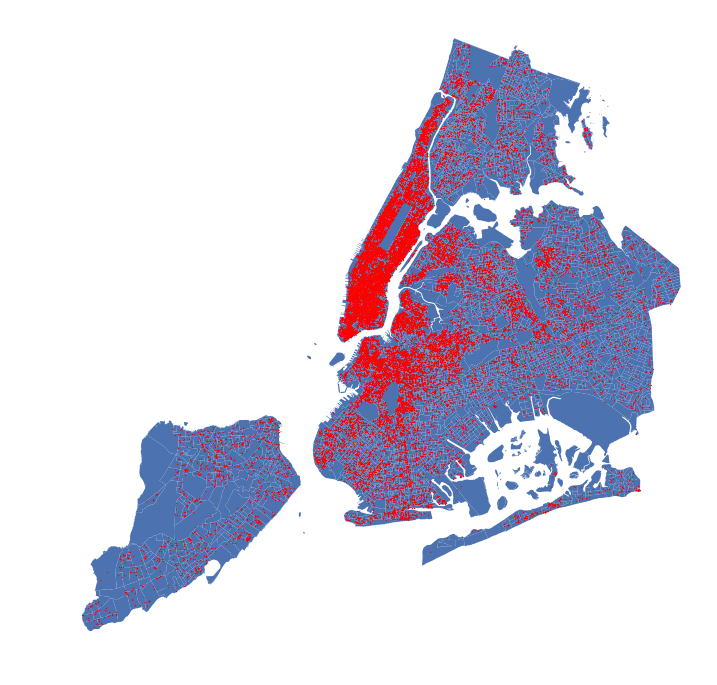

In [396]:
base = census_df.plot(figsize=(12,12))
base.axis('off')
df.plot(ax=base,color='red',markersize=1)

Plotting the complaints on the census block group basemap just to verify that the complaints and census block groups are in the same spatial frame.

In [397]:
df_zoned_census = gpd.sjoin(df_zoned,census_df)

In [398]:
df_zoned_census.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lonlat', 'geometry',
       'OBJECTID_left', 'ZONEDIST', 'Shape_Leng', 'Shape_Area', 'index_right',
       'OBJECTID_right', 'total_population', 'white_population',
      

In [399]:
df_zoned_census.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,index_right,OBJECTID_right,total_population,white_population,african_american_population,american_indian_population,asian_population,native_hawaiian_population,median_age,per_capita_income
0,34500485,10/09/2016 07:25:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,90 GOLD STREET,...,1825,7768,2402.0,1465.0,220.0,0.0,641.0,0.0,57.8,35807.0
382,33323036,05/10/2016 08:21:00 PM,05/16/2016 08:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,299 PEARL STREET,...,1825,7768,2402.0,1465.0,220.0,0.0,641.0,0.0,57.8,35807.0
3062,32460868,01/20/2016 07:46:00 AM,01/21/2016 02:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,NaN,...,1825,7768,2402.0,1465.0,220.0,0.0,641.0,0.0,57.8,35807.0
8181,32775498,02/25/2016 11:16:00 PM,03/03/2016 01:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,NaN,...,1825,7768,2402.0,1465.0,220.0,0.0,641.0,0.0,57.8,35807.0
8228,32777549,02/26/2016 11:56:00 PM,03/03/2016 05:59:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,NaN,...,1825,7768,2402.0,1465.0,220.0,0.0,641.0,0.0,57.8,35807.0


In [400]:
df_zoned_census.shape

(57623, 57)

## 1.3 Weather Data

Obtaining weather information in New York City for each of the days of complaints. The team at DEP conveyed to us that the volume of the complaints change over different seasons so we thought it would be useful to include this information. This information was accessed using the database from National Oceanic and Atmospheric Adminstration(NOAA) https://www.ncdc.noaa.gov/

In [401]:
weather_data = pd.read_csv('2016_weather.csv')

In [402]:
weather_data_ny = weather_data[['DATE','TAVG','SNWD','PRCP']]

In [ ]:
weather_data_ny[['DATE','TAVG','SNWD','PRCP']].dropna()
weather_data_ny['DATE'] = pd.to_datetime(weather_data_ny['DATE']).dt.date
weather_data_ny.rename(columns={'DATE':'date','TAVG':'average_temparature','SNWD':'snow_levels','PRCP':'precipitation_levels'},\
                      inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [ ]:
df_zoned_census['Created Date'] = pd.to_datetime(df_zoned_census['Created Date'])
df_zoned_census['Closed Date'] = pd.to_datetime(df_zoned_census['Closed Date'])

In [ ]:
df_zoned_census['created_date_wo_time'] = df_zoned_census['Created Date'].dt.date
combined_df = df_zoned_census.merge(weather_data_ny,left_on='created_date_wo_time',right_on='date')

In [ ]:
combined_df.columns

In [ ]:
combined_df.columns

In [ ]:
combined_df.head()

In [ ]:
list(combined_df.sort_values(by='Resolution Description')['Resolution Description'].unique())

In [ ]:
combined_df['ZONEDIST'].unique()

Creating numerical labels for each of the string variables which can be input into the random forrest model.

In [ ]:
zonedist_dict = {'R8':154, 'R8B':1, 'C4-5X':2, 'C5-5':3, 'R6A':4, 'R5D':5, 'M2-3':6, 'C1-8A':7,
       'C1-9A':8, 'M1-5/R7X':9, 'C5-2':10, 'R6':11, 'M1-2':12, 'C6-3':13, 'C4-7':14, 'C6-2A':15,
       'R6B':16, 'C6-1':17, 'R10':18, 'R1-2':19, 'R7B':20, 'R4':21, 'R7-2':22, 'C6-2':23, 'C1-9':24,
       'R5':25, 'R8X':26, 'R5B':27, 'R8A':28, 'C6-1G':29, 'R3X':30, 'R4-1':31, 'C4-4A':32, 'C4-3A':33,
       'R3-2':34, 'R7-1':35, 'C6-4':36, 'C6-3A':37, 'C5-2A':38, 'R7A':39, 'C5-3':40, 'R3A':41,
       'M1-5':42, 'M1-5A':43, 'C2-8':44, 'R3-1':45, 'C1-6A':46, 'R7D':47, 'C1-7':48, 'R10A':49,
       'C4-6A':50, 'C6-3X':51, 'C6-4X':52, 'C6-6.5':53, 'C6-9':54, 'M1-2/R6A':55, 'C4-4':56,
       'C4-2':57, 'R2':58, 'M1-1':59, 'M3-1':60, 'R2X':61, 'M1-4/R6A':62, 'R1-2A':63, 'R2A':64,
       'R4A':65, 'M1-5B':66, 'M1-5/R9':67, 'M1-6':68, 'C6-4A':69, 'M1-4':70, 'C6-6':71,
       'C6-4.5':72, 'C5-P':73, 'C5-1':74, 'C6-4M':75, 'R9A':76, 'M1-6D':77, 'C2-8A':78, 'C6-2G':79,
       'M1-1D':80, 'C1-6':81, 'R9':82, 'C1-8X':83, 'C5-2.5':84, 'C8-4':85, 'C4-4D':86, 'C1-8':87,
       'C8-1':88, 'M2-1':89, 'M1-6/R10':90, 'M1-5/R7-3':91, 'C4-6':92, 'C4-5A':93, 'C2-6':94,
       'M1-2D':95, 'BPC':96, 'M1-4/R6B':97, 'C6-7':98, 'R7-3':99, 'R4B':100, 'M1-2/R6B':101,
       'C4-3':102, 'C4-2A':103, 'R10H':104, 'M3-2':105, 'R1-1':106, 'C4-5':107, 'M1-2/R6':108, 'R5A':109,
       'PARK':110, 'C6-5':111, 'C5-4':112, 'M1-5M':113, 'C6-2M':114, 'C4-5D':115, 'R7X':116, 'C4-4L':117,
       'C2-7A':118, 'C8-2':119, 'M1-4/R7A':120, 'M2-4':121, 'C3A':122, 'M1-4D':123, 'C2-7':124,
       'C6-1A':125, 'C5-1A':126, 'M1-4/R8A':127, 'M1-2/R5D':128, 'C4-1':129, 'C6-7T':130, 'C6-5.5':131,
       'M1-4/R7-2':132, 'C1-7A':133, 'M1-2/R7A':134, 'C8-3':135, 'M1-4/R7X':136, 'R9X':137,
       'M1-2/R5B':138, 'M1-2/R8A':139, 'M1-3':140, 'M1-1/R7-2':141, 'M1-5/R8A':142, 'C4-2F':143,
       'C3':144, 'nan':0, 'M1-2/R8':145, 'C2-6A':146, 'M1-1/R5':147, 'M1-5/R9-1':148, 'C6-3D':149,
       'C7':150, 'M1-3/R7X':151, 'M1-3/R8':152, 'M1-5/R7-2':153}

In [ ]:
descriptor_dict = {
    'Noise: Construction Before/After Hours (NM1)':0,
       'Noise: Alarms (NR3)':1, 'Noise: Boat(Engine,Music,Etc) (NR10)':2,
       'Noise: Construction Equipment (NC1)':3, 'Noise, Barking Dog (NR5)':4,
       'Noise: Jack Hammering (NC2)':5,
       'Noise: air condition/ventilation equipment (NV1)':6,
       'Noise, Ice Cream Truck (NR4)':7, 'Noise: Manufacturing Noise (NK1)':8,
       'Noise: Private Carting Noise (NQ1)':9,
       'Noise:  lawn care equipment (NCL)':10, 'Noise, Other Animals (NR6)':11,
       'Noise: Other Noise Sources (Use Comments) (NZZ)':12,
       'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)':13,
       'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)':14,
       'Noise: Vehicle (NR2)':15
}

# Priority mapping

Here we assign priority labels to the resolution descriptions. A priority score of 1 means that the DEP inspectors were able to visit the complaint site and address the source of noise. A score of 2 means that the DEP inspectors were not able to close the complaint upon visit.

In [ ]:
dict3 = {
    'The Department of Environmental Protection attempted to contact the complainant by phone, but the phone number provided was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct phone number. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection attempted to inspect this complaint but could not gain access to the location. If the problem still exists, please call 311 and file a new complaint with additional access information. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection attempted to investigate this complaint but the address was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct address. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 "The Department of Environmental Protection closed or canceled this complaint at the complainant's request.":2,
 'The Department of Environmental Protection conducted an inspection and determined that "No Horn Honking" or "No Idling" signs are not warranted. If the problem still exists, please call 311 and file a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection conducted an inspection and determined that "No Horn Honking" or "No Idling" signs are warranted. A request will be sent to the Department of Transportation to have the sign(s) installed.':1,
 'The Department of Environmental Protection determined that an inspection is not warranted to investigate this complaint at this time and sent a letter to the complainant and/or respondent.':2,
 'The Department of Environmental Protection determined that an inspection is warranted to investigate this complaint.':2,
 'The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.':0,
 'The Department of Environmental Protection determined that this complaint is not under its jurisdiction and referred it to the New York Police Department for further action.':2,
 'The Department of Environmental Protection did not observe a violation of the New York City Air/Noise Code at the time of inspection and could not issue a notice of violation. If the problem still exists, please call 311 and file a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection has inspected your complaint and determined that further investigation is required. More information will be available once the condition is resolved. Please visit nyc.gov/311 or call 311 at a later time to check the status of your complaint.':2,
 'The Department of Environmental Protection investigated this complaint and made a repair.':1,
 'The Department of Environmental Protection investigated this complaint and shut the running hydrant.':1,
 'The Department of Environmental Protection observed a violation of the New York City Air/Noise Code at the time of inspection and issued a notice of violation.':1,
 'The Department of Environmental Protection received a letter or phone call from the alleged dog owner in response to a letter or inspection.':2,
 'The Department of Environmental Protection received a response from the complainant with additional information that was requested to assist in investigation of the complaint (see resolution code A22).':2,
 'The Department of Environmental Protection requires an appointment to inspect this complaint type.  Complainant information was not provided and an appointment could not be scheduled.  The complaint has been closed. If the problem still exists, please call 311 and file a new complaint including your contact information.':2,
 'The Department of Environmental Protection requires contact with the complainant to investigate this complaint. A message was left for the complainant at the phone number provided.':2,
 'The Department of Environmental Protection requires contact with the complainant to investigate this complaint. The complaint was closed because attempts made to contact the complainant by phone and/or letter received no response.':2,
 'The Department of Environmental Protection researched this complaint and determined that it could be closed.':2,
 'The Department of Environmental Protection resolved this complaint by speaking to the complainant on the phone.':2,
 'The Department of Environmental Protection scheduled an inspection.':2,
 'The Department of Environmental Protection sent a letter to the complainant and/or respondent and the letter was returned as undeliverable.':2,
 'The status of this Service Request is currently not available online. Please call 311 for further assistance. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':0,
    'nan':0
}

In [ ]:
combined_df['enforcability_score'] = combined_df['Resolution Description'].apply(lambda x: dict3[str(x)])
combined_df['Descriptor_cat'] = combined_df['Descriptor'].apply(lambda x: descriptor_dict2[str(x)])
combined_df['zonedist_cat'] = combined_df['ZONEDIST'].apply(lambda x: zonedist_dict[str(x)])

In [ ]:
filtered_combined_df = combined_df[combined_df['enforcability_score'] != 0]
filtered_combined_df = filtered_combined_df[filtered_combined_df['zonedist_cat'] != 0]

In [ ]:
filtered_combined_df.Descriptor.unique()

In [ ]:
sns.heatmap(filtered_combined_df.corr())

# AHV Files

In [ ]:
counter = 0
for file in listdir('ahv_assigned_files'):
    filename = 'ahv_assigned_files/'+file
    if counter == 0:
        ahv_assigned = pd.read_csv(filename)
        counter += 1
    else:
        ahv_assigned = pd.concat([ahv_assigned,pd.read_csv(filename)])

In [ ]:
ahv_assigned.shape

In [ ]:
ahv_assigned = ahv_assigned[['Unique Key','AHV']]

In [ ]:
filtered_combined_df.columns

In [575]:
filtered_combined_df_with_AHV =  filtered_combined_df.merge(ahv_assigned,how='left',on='Unique Key')

In [576]:
filtered_combined_df_with_AHV.AHV.fillna(value=0,inplace=True)

In [577]:
feature_space = filtered_combined_df_with_AHV[['Descriptor_cat','AHV',\
                                               'total_population', 'median_age',\
                                               'per_capita_income','average_temparature', 'precipitation_levels',\
                                               'snow_levels','zonedist_cat']]
output_space = filtered_combined_df_with_AHV['enforcability_score']
x_train, x_test, y_train, y_test = train_test_split(feature_space, output_space, test_size=0.30, random_state=42)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


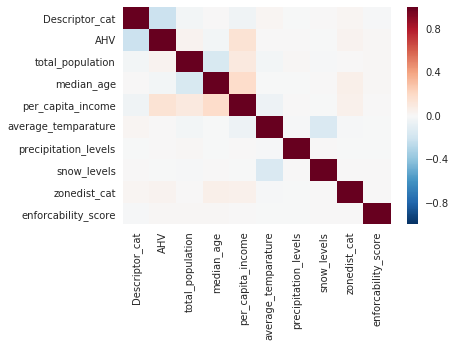

In [578]:
sns.heatmap(filtered_combined_df_with_AHV[['Descriptor_cat','AHV',\
                                               'total_population', 'median_age',\
                                               'per_capita_income','average_temparature', 'precipitation_levels',\
                                               'snow_levels','zonedist_cat','enforcability_score']].corr())

In [579]:
model = RandomForestClassifier(random_state=0,n_estimators=100,class_weight='balanced')
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [580]:
model.feature_importances_

array([ 0.16887153,  0.02123061,  0.16216019,  0.14841221,  0.16035547,
        0.16232765,  0.06103225,  0.00643948,  0.10917062])

In [581]:
model.score(x_test,y_test)

0.96625899280575545

In [582]:
y_pred = model.predict(x_test)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


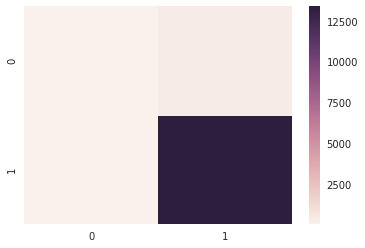

In [583]:
sns.heatmap(confusion_matrix(y_test, y_pred))

This figure tells us that our model has a high accuracy as it predicts most of the complaints as unenforcable.

In [584]:
from sklearn import preprocessing

In [585]:
x_test.shape

(13900, 9)

In [586]:
confusion_matrix(y_test, y_pred)

array([[   37,   393],
       [   76, 13394]])

In [587]:
def f_score(A):
    pr = A[0][0]/(A[0][0]+A[0][1])
    re = A[0][0]/(A[0][0]+A[1][0])
    score = (2*pr*re)/(pr+re)
    print(score)

In [588]:
f_score(confusion_matrix(y_test, y_pred))

0.136279926335


In [589]:
combined_df['Resolution Description'].unique()

array([ 'The Department of Environmental Protection has inspected your complaint and determined that further investigation is required. More information will be available once the condition is resolved. Please visit nyc.gov/311 or call 311 at a later time to check the status of your complaint.',
       'The Department of Environmental Protection did not observe a violation of the New York City Air/Noise Code at the time of inspection and could not issue a notice of violation. If the problem still exists, please call 311 and file a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
       'The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.',
       'The Department of Environmental Protection researched this complaint and determined that it could be closed.',
       'The Department of Environmental Protection sent a letter to the 

# Adding more American Community Survey features and PLUTO features

In [590]:
pluto_features = gpd.GeoDataFrame.from_file('pluto_cbg.geojson')
pluto_features.drop(['GEOID'],axis=1,inplace=True)

In [591]:
pluto_features = pluto_features.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


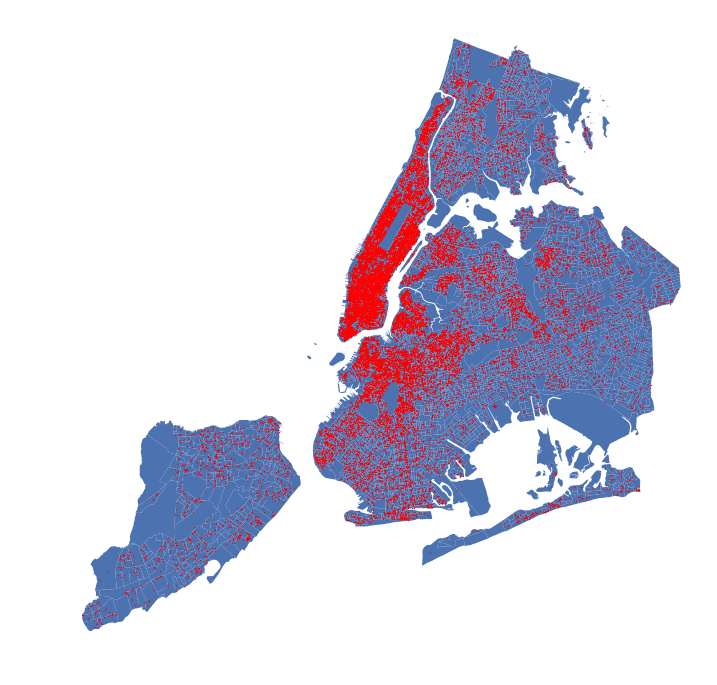

In [592]:
base = pluto_features.plot(figsize=(12,12))
base.axis('off')
filtered_combined_df_with_AHV.plot(ax=base,color='red',markersize=1)

In [593]:
pluto_features.columns

Index(['lotarea', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'assessland', 'yearbuilt',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'overlay1', 'bldgclass',
       'landuse', 'lottype', 'simple_zone', 'geometry'],
      dtype='object')

In [594]:
overlay1_dict = {'U':0, 'C1':1, 'C2':2}
bldgclass_dict = {'C':0, 'A':1, 'B':2, 'D':3, 'K':4, 'Z':5, 'G':6, 'S':7, 'P':8, 'R':9, 'T':10, 'F':11, 'O':12,\
       'I':13, 'U':14, 'E':15, 'W':16, 'Q':17, 'M':18, 'Y':19, 'H':20, 'J':21, 'V':22, 'N':23, 'L':24}
simple_zone_dict = {'R7':0, 'R6':1, 'R5':2, 'M1':3, 'C4':4, 'R8':5, 'R4':6, 'R3':7, 'R2':8, 'C7':9, 'C8':10,\
       'O':11, 'M3':12, 'C5':13, 'C6':14, 'R10':15, 'R1':16, 'C1':17, 'R9':18, 'M2':19, 'P':20, 'C2':21,
       'C3':22}

In [595]:
pluto_features['overlay1_cat'] = pluto_features['overlay1'].apply(lambda x:overlay1_dict[x])
pluto_features['bldgclass_cat'] = pluto_features['bldgclass'].apply(lambda x:bldgclass_dict[x])
pluto_features['simple_zone_cat'] = pluto_features['simple_zone'].apply(lambda x:simple_zone_dict[x])

In [596]:
census_df_all_features = gpd.GeoDataFrame.from_file('acs_2016_demo.shp')

In [597]:
census_df_all_features = census_df_all_features.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


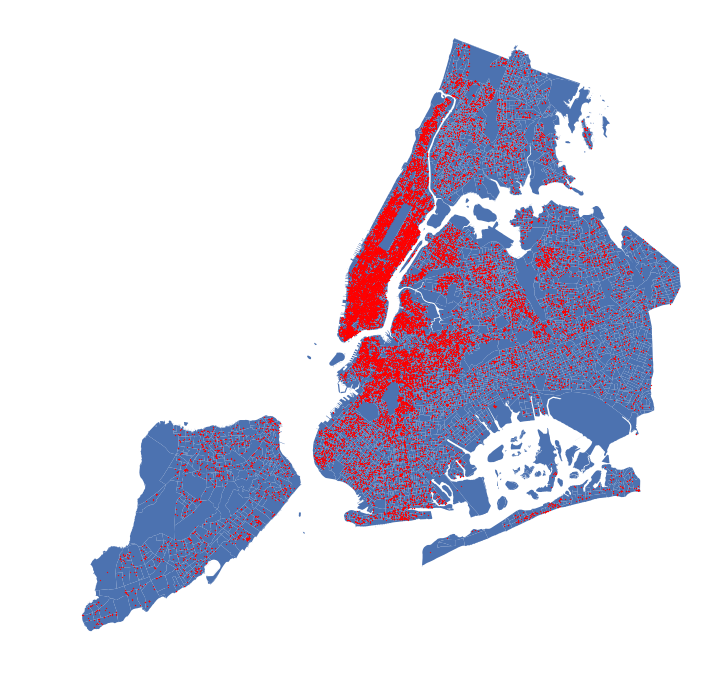

In [598]:
base = census_df_all_features.plot(figsize=(12,12))
base.axis('off')
filtered_combined_df_with_AHV.plot(ax=base,color='red',markersize=1)

In [599]:
filtered_combined_df_with_AHV.drop(['index_right'],axis=1,inplace=True)

In [600]:
filtered_combined_df_added_census = gpd.sjoin(filtered_combined_df_with_AHV, census_df_all_features,how='left')

In [601]:
filtered_combined_df_added_census['hour_of_the_day'] = filtered_combined_df_added_census['Created Date'].dt.hour

In [602]:
filtered_combined_df_added_census.drop(['index_right'],axis=1,inplace=True)
filtered_combined_df_added_census_pluto = gpd.sjoin(filtered_combined_df_added_census,pluto_features,how='left')

In [603]:
input_features = ['hour_of_the_day',
 'average_temparature',
 'snow_levels',
 'precipitation_levels',
 'Descriptor_cat',
 'zonedist_cat',
 'AHV',
 'B02001e1',
 'B02001m1',
 'B02001e2',
 'B02001m2',
 'B02001e3',
 'B02001m3',
 'B02001e4',
 'B02001m4',
 'B02001e5',
 'B02001m5',
 'B02001e6',
 'B02001m6',
 'B02001e7',
 'B02001m7',
 'B02001e8',
 'B02001m8',
 'B02001e9',
 'B02001m9',
 'B02001e10',
 'B02001m10',
 'B02008e1',
 'B02008m1',
 'B02009e1',
 'B02009m1',
 'B02010e1',
 'B02010m1',
 'B02011e1',
 'B02011m1',
 'B02012e1',
 'B02012m1',
 'B02013e1',
 'B02013m1',
 'C02003e1',
 'C02003m1',
 'C02003e2',
 'C02003m2',
 'C02003e3',
 'C02003m3',
 'C02003e4',
 'C02003m4',
 'C02003e5',
 'C02003m5',
 'C02003e6',
 'C02003m6',
 'C02003e7',
 'C02003m7',
 'C02003e8',
 'C02003m8',
 'C02003e9',
 'C02003m9',
 'C02003e10',
 'C02003m10',
 'C02003e11',
 'C02003m11',
 'C02003e12',
 'C02003m12',
 'C02003e13',
 'C02003m13',
 'C02003e14',
 'C02003m14',
 'C02003e15',
 'C02003m15',
 'C02003e16',
 'C02003m16',
 'C02003e17',
 'C02003m17',
 'C02003e18',
 'C02003m18',
 'C02003e19',
 'C02003m19',
 'B01001e1',
 'B01001m1',
 'B01001e2',
 'B01001m2',
 'B01001e3',
 'B01001m3',
 'B01001e4',
 'B01001m4',
 'B01001e5',
 'B01001m5',
 'B01001e6',
 'B01001m6',
 'B01001e7',
 'B01001m7',
 'B01001e8',
 'B01001m8',
 'B01001e9',
 'B01001m9',
 'B01001e10',
 'B01001m10',
 'B01001e11',
 'B01001m11',
 'B01001e12',
 'B01001m12',
 'B01001e13',
 'B01001m13',
 'B01001e14',
 'B01001m14',
 'B01001e15',
 'B01001m15',
 'B01001e16',
 'B01001m16',
 'B01001e17',
 'B01001m17',
 'B01001e18',
 'B01001m18',
 'B01001e19',
 'B01001m19',
 'B01001e20',
 'B01001m20',
 'B01001e21',
 'B01001m21',
 'B01001e22',
 'B01001m22',
 'B01001e23',
 'B01001m23',
 'B01001e24',
 'B01001m24',
 'B01001e25',
 'B01001m25',
 'B01001e26',
 'B01001m26',
 'B01001e27',
 'B01001m27',
 'B01001e28',
 'B01001m28',
 'B01001e29',
 'B01001m29',
 'B01001e30',
 'B01001m30',
 'B01001e31',
 'B01001m31',
 'B01001e32',
 'B01001m32',
 'B01001e33',
 'B01001m33',
 'B01001e34',
 'B01001m34',
 'B01001e35',
 'B01001m35',
 'B01001e36',
 'B01001m36',
 'B01001e37',
 'B01001m37',
 'B01001e38',
 'B01001m38',
 'B01001e39',
 'B01001m39',
 'B01001e40',
 'B01001m40',
 'B01001e41',
 'B01001m41',
 'B01001e42',
 'B01001m42',
 'B01001e43',
 'B01001m43',
 'B01001e44',
 'B01001m44',
 'B01001e45',
 'B01001m45',
 'B01001e46',
 'B01001m46',
 'B01001e47',
 'B01001m47',
 'B01001e48',
 'B01001m48',
 'B01001e49',
 'B01001m49',
 'B01002e1',
 'B01002m1',
 'B01002e2',
 'B01002m2',
 'B01002e3',
 'B01002m3',
 'B01002Ae1',
 'B01002Am1',
 'B01002Ae2',
 'B01002Am2',
 'B01002Ae3',
 'B01002Am3',
 'B01002Be1',
 'B01002Bm1',
 'B01002Be2',
 'B01002Bm2',
 'B01002Be3',
 'B01002Bm3',
 'B01002Ce1',
 'B01002Cm1',
 'B01002Ce2',
 'B01002Cm2',
 'B01002Ce3',
 'B01002Cm3',
 'B01002De1',
 'B01002Dm1',
 'B01002De2',
 'B01002Dm2',
 'B01002De3',
 'B01002Dm3',
 'B01002Ee1',
 'B01002Em1',
 'B01002Ee2',
 'B01002Em2',
 'B01002Ee3',
 'B01002Em3',
 'B01002Fe1',
 'B01002Fm1',
 'B01002Fe2',
 'B01002Fm2',
 'B01002Fe3',
 'B01002Fm3',
 'B01002Ge1',
 'B01002Gm1',
 'B01002Ge2',
 'B01002Gm2',
 'B01002Ge3',
 'B01002Gm3',
 'B01002He1',
 'B01002Hm1',
 'B01002He2',
 'B01002Hm2',
 'B01002He3',
 'B01002Hm3',
 'B01002Ie1',
 'B01002Im1',
 'B01002Ie2',
 'B01002Im2',
 'B01002Ie3',
 'B01002Im3',
 'B01003e1',
 'B01003m1',
 'B19001e1',
 'B19001m1',
 'B19001e2',
 'B19001m2',
 'B19001e3',
 'B19001m3',
 'B19001e4',
 'B19001m4',
 'B19001e5',
 'B19001m5',
 'B19001e6',
 'B19001m6',
 'B19001e7',
 'B19001m7',
 'B19001e8',
 'B19001m8',
 'B19001e9',
 'B19001m9',
 'B19001e10',
 'B19001m10',
 'B19001e11',
 'B19001m11',
 'B19001e12',
 'B19001m12',
 'B19001e13',
 'B19001m13',
 'B19001e14',
 'B19001m14',
 'B19001e15',
 'B19001m15',
 'B19001e16',
 'B19001m16',
 'B19001e17',
 'B19001m17',
 'B19013e1',
 'B19013m1',
 'B19025e1',
 'B19025m1',
 'B19025Ae1',
 'B19025Am1',
 'B19025Be1',
 'B19025Bm1',
 'B19025Ce1',
 'B19025Cm1',
 'B19025De1',
 'B19025Dm1',
 'B19025Ee1',
 'B19025Em1',
 'B19025Fe1',
 'B19025Fm1',
 'B19025Ge1',
 'B19025Gm1',
 'B19025He1',
 'B19025Hm1',
 'B19025Ie1',
 'B19025Im1',
 'B19037e1',
 'B19037m1',
 'B19037e2',
 'B19037m2',
 'B19037e3',
 'B19037m3',
 'B19037e4',
 'B19037m4',
 'B19037e5',
 'B19037m5',
 'B19037e6',
 'B19037m6',
 'B19037e7',
 'B19037m7',
 'B19037e8',
 'B19037m8',
 'B19037e9',
 'B19037m9',
 'B19037e10',
 'B19037m10',
 'B19037e11',
 'B19037m11',
 'B19037e12',
 'B19037m12',
 'B19037e13',
 'B19037m13',
 'B19037e14',
 'B19037m14',
 'B19037e15',
 'B19037m15',
 'B19037e16',
 'B19037m16',
 'B19037e17',
 'B19037m17',
 'B19037e18',
 'B19037m18',
 'B19037e19',
 'B19037m19',
 'B19037e20',
 'B19037m20',
 'B19037e21',
 'B19037m21',
 'B19037e22',
 'B19037m22',
 'B19037e23',
 'B19037m23',
 'B19037e24',
 'B19037m24',
 'B19037e25',
 'B19037m25',
 'B19037e26',
 'B19037m26',
 'B19037e27',
 'B19037m27',
 'B19037e28',
 'B19037m28',
 'B19037e29',
 'B19037m29',
 'B19037e30',
 'B19037m30',
 'B19037e31',
 'B19037m31',
 'B19037e32',
 'B19037m32',
 'B19037e33',
 'B19037m33',
 'B19037e34',
 'B19037m34',
 'B19037e35',
 'B19037m35',
 'B19037e36',
 'B19037m36',
 'B19037e37',
 'B19037m37',
 'B19037e38',
 'B19037m38',
 'B19037e39',
 'B19037m39',
 'B19037e40',
 'B19037m40',
 'B19037e41',
 'B19037m41',
 'B19037e42',
 'B19037m42',
 'B19037e43',
 'B19037m43',
 'B19037e44',
 'B19037m44',
 'B19037e45',
 'B19037m45',
 'B19037e46',
 'B19037m46',
 'B19037e47',
 'B19037m47',
 'B19037e48',
 'B19037m48',
 'B19037e49',
 'B19037m49',
 'B19037e50',
 'B19037m50',
 'B19037e51',
 'B19037m51',
 'B19037e52',
 'B19037m52',
 'B19037e53',
 'B19037m53',
 'B19037e54',
 'B19037m54',
 'B19037e55',
 'B19037m55',
 'B19037e56',
 'B19037m56',
 'B19037e57',
 'B19037m57',
 'B19037e58',
 'B19037m58',
 'B19037e59',
 'B19037m59',
 'B19037e60',
 'B19037m60',
 'B19037e61',
 'B19037m61',
 'B19037e62',
 'B19037m62',
 'B19037e63',
 'B19037m63',
 'B19037e64',
 'B19037m64',
 'B19037e65',
 'B19037m65',
 'B19037e66',
 'B19037m66',
 'B19037e67',
 'B19037m67',
 'B19037e68',
 'B19037m68',
 'B19037e69',
 'B19037m69',
 'B19049e1',
 'B19049m1',
 'B19049e2',
 'B19049m2',
 'B19049e3',
 'B19049m3',
 'B19049e4',
 'B19049m4',
 'B19049e5',
 'B19049m5',
 'B19050e1',
 'B19050m1',
 'B19050e2',
 'B19050m2',
 'B19050e3',
 'B19050m3',
 'B19050e4',
 'B19050m4',
 'B19050e5',
 'B19050m5',
 'B19051e1',
 'B19051m1',
 'B19051e2',
 'B19051m2',
 'B19051e3',
 'B19051m3',
 'B19052e1',
 'B19052m1',
 'B19052e2',
 'B19052m2',
 'B19052e3',
 'B19052m3',
 'B19053e1',
 'B19053m1',
 'B19053e2',
 'B19053m2',
 'B19053e3',
 'B19053m3',
 'B19054e1',
 'B19054m1',
 'B19054e2',
 'B19054m2',
 'B19054e3',
 'B19054m3',
 'B19055e1',
 'B19055m1',
 'B19055e2',
 'B19055m2',
 'B19055e3',
 'B19055m3',
 'B19056e1',
 'B19056m1',
 'B19056e2',
 'B19056m2',
 'B19056e3',
 'B19056m3',
 'B19057e1',
 'B19057m1',
 'B19057e2',
 'B19057m2',
 'B19057e3',
 'B19057m3',
 'B19059e1',
 'B19059m1',
 'B19059e2',
 'B19059m2',
 'B19059e3',
 'B19059m3',
 'B19060e1',
 'B19060m1',
 'B19060e2',
 'B19060m2',
 'B19060e3',
 'B19060m3',
 'B19061e1',
 'B19061m1',
 'B19062e1',
 'B19062m1',
 'B19063e1',
 'B19063m1',
 'B19064e1',
 'B19064m1',
 'B19065e1',
 'B19065m1',
 'B19066e1',
 'B19066m1',
 'B19067e1',
 'B19067m1',
 'B19069e1',
 'B19069m1',
 'B19070e1',
 'B19070m1',
 'B19101e1',
 'B19101m1',
 'B19101e2',
 'B19101m2',
 'B19101e3',
 'B19101m3',
 'B19101e4',
 'B19101m4',
 'B19101e5',
 'B19101m5',
 'B19101e6',
 'B19101m6',
 'B19101e7',
 'B19101m7',
 'B19101e8',
 'B19101m8',
 'B19101e9',
 'B19101m9',
 'B19101e10',
 'B19101m10',
 'B19101e11',
 'B19101m11',
 'B19101e12',
 'B19101m12',
 'B19101e13',
 'B19101m13',
 'B19101e14',
 'B19101m14',
 'B19101e15',
 'B19101m15',
 'B19101e16',
 'B19101m16',
 'B19101e17',
 'B19101m17',
 'B19127e1',
 'B19127m1',
 'B19201e1',
 'B19201m1',
 'B19201e2',
 'B19201m2',
 'B19201e3',
 'B19201m3',
 'B19201e4',
 'B19201m4',
 'B19201e5',
 'B19201m5',
 'B19201e6',
 'B19201m6',
 'B19201e7',
 'B19201m7',
 'B19201e8',
 'B19201m8',
 'B19201e9',
 'B19201m9',
 'B19201e10',
 'B19201m10',
 'B19201e11',
 'B19201m11',
 'B19201e12',
 'B19201m12',
 'B19201e13',
 'B19201m13',
 'B19201e14',
 'B19201m14',
 'B19201e15',
 'B19201m15',
 'B19201e16',
 'B19201m16',
 'B19201e17',
 'B19201m17',
 'B19202e1',
 'B19202m1',
 'B19214e1',
 'B19214m1',
 'B19301e1',
 'B19301m1',
 'B19301Ae1',
 'B19301Am1',
 'B19301Be1',
 'B19301Bm1',
 'B19301Ce1',
 'B19301Cm1',
 'B19301De1',
 'B19301Dm1',
 'B19301Ee1',
 'B19301Em1',
 'B19301Fe1',
 'B19301Fm1',
 'B19301Ge1',
 'B19301Gm1',
 'B19301He1',
 'B19301Hm1',
 'B19301Ie1',
 'B19301Im1',
 'B19313e1',
 'B19313m1',
 'B19313Ae1',
 'B19313Am1',
 'B19313Be1',
 'B19313Bm1',
 'B19313Ce1',
 'B19313Cm1',
 'B19313De1',
 'B19313Dm1',
 'B19313Ee1',
 'B19313Em1',
 'B19313Fe1',
 'B19313Fm1',
 'B19313Ge1',
 'B19313Gm1',
 'B19313He1',
 'B19313Hm1',
 'B19313Ie1',
 'B19313Im1',
 'B00001e1',
 'B00001m1',
 'B00002e1',
 'B00002m1','lotarea', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',\
       'lotdepth', 'bldgfront', 'bldgdepth', 'assessland', 'yearbuilt',\
       'builtfar', 'residfar', 'commfar', 'facilfar', 'overlay1_cat', 'bldgclass_cat',\
       'landuse', 'lottype', 'simple_zone_cat']

# Testing for all complaints and all features

In [660]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1][input_features],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3)
unenforcable_data = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].sample(n=1470)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[input_features],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3)
                                                    

In [661]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [662]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [663]:
model_with_all_features.score(x_test,y_test)

0.62244897959183676

In [664]:
y_pred = model_with_all_features.predict(x_test)

In [665]:
confusion_matrix(y_pred,y_test)

array([[270, 162],
       [171, 279]])

In [666]:
f_score(confusion_matrix(y_pred,y_test))

0.618556701031


In [667]:
subset = filtered_combined_df_added_census_pluto.sample(n=1000,random_state=42)
confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score'])

array([[ 32, 399],
       [  2, 567]])

In [668]:
f_score(confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score']))

0.137634408602


# Testing for all complaints and selected features

In [669]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])
selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [671]:
feature_importance[:10]

,Features,Importance
0,hour_of_the_day,0.0589899
1,average_temparature,0.0496401
2,snow_levels,0.00261972
3,precipitation_levels,0.0190833
4,Descriptor_cat,0.041804
5,zonedist_cat,0.01855
6,AHV,0.0134631
7,B02001e1,0.00148687
8,B02001m1,0.00174812
9,B02001e2,0.0014498


In [672]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1][selected_columns],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3)
unenforcable_data = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].sample(n=1470)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[selected_columns],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3)
                                                    

In [673]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [674]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [675]:
model_with_all_features.score(x_test,y_test)

0.70634920634920639

In [676]:
y_pred = model_with_all_features.predict(x_test)

In [677]:
confusion_matrix(y_pred,y_test)

array([[308, 126],
       [133, 315]])

In [678]:
f_score(confusion_matrix(y_pred,y_test))

0.704


In [679]:
subset = filtered_combined_df_added_census_pluto.sample(n=1000,random_state=42)
confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score'])

array([[ 31, 313],
       [  3, 653]])

In [680]:
f_score(confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score']))

0.164021164021


# Testing for construction with all features

In [698]:
construction_labels = ['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)','Noise: Jack Hammering (NC2)']
construction_complaints_all_features = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                               .Descriptor.isin(construction_labels)]

In [699]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1][input_features],
                                                    construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3)
unenforcable_data = construction_complaints_all_features[construction_complaints_all_features.enforcability_score == 2].sample(n=957)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[input_features],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3)
                                                    

In [700]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [701]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [702]:
model_with_all_features.score(x_test,y_test)

0.59722222222222221

In [703]:
y_pred = model_with_all_features.predict(x_test)

In [704]:
confusion_matrix(y_pred,y_test)

array([[182, 126],
       [106, 162]])

In [705]:
f_score(confusion_matrix(y_pred,y_test))

0.610738255034


In [706]:
subset = construction_complaints_all_features.sample(n=1000,random_state=42)
confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score'])

array([[ 30, 414],
       [  4, 552]])

In [707]:
f_score(confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score']))

0.125523012552


In [708]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])

In [709]:
feature_importance[:10]

,Features,Importance
0,hour_of_the_day,0.0705688
1,average_temparature,0.0537897
2,snow_levels,0.00169685
3,precipitation_levels,0.0205041
4,Descriptor_cat,0.0185475
5,zonedist_cat,0.0227934
6,AHV,0.00865729
7,B02001e1,0.00185328
8,B02001m1,0.000944647
9,B02001e2,0.0011094


In [710]:
selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [711]:
construction_complaints_all_features[construction_complaints_all_features['AHV'] == 0].shape

(2771, 746)

In [712]:
construction_complaints_all_features[(construction_complaints_all_features['AHV'] == 1) & \
                                     (construction_complaints_all_features['enforcability_score'] == 1)].shape

(850, 746)

# Testing for just construction complaints and selected features

In [713]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1][selected_columns],
                                                    construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3)
unenforcable_data = construction_complaints_all_features[construction_complaints_all_features.enforcability_score == 2].sample(n=957)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[selected_columns],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3)
                                                    

In [714]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [715]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [716]:
model_with_all_features.score(x_test,y_test)

0.60243055555555558

In [717]:
y_pred = model_with_all_features.predict(x_test)

In [718]:
confusion_matrix(y_pred,y_test)

array([[187, 128],
       [101, 160]])

In [719]:
f_score(confusion_matrix(y_pred,y_test))

0.620232172471


In [720]:
subset = construction_complaints_all_features.sample(n=1000,random_state=42)
confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score'])

array([[ 31, 380],
       [  3, 586]])

In [721]:
f_score(confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score']))

0.139325842697


In [722]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])

In [723]:
feature_importance.sort_values(by='Importance',ascending=False)

,Features,Importance
0,hour_of_the_day,0.181447
7,unitstotal,0.130913
6,assessland,0.130127
9,builtfar,0.128401
1,average_temparature,0.126331
8,numfloors,0.120001
2,zonedist_cat,0.0932283
3,precipitation_levels,0.0552779
4,Descriptor_cat,0.0203794
5,AHV,0.0138951


In [724]:
construction_complaints_all_features[construction_complaints_all_features['AHV'] == 0].shape

(2771, 746)

In [725]:
construction_complaints_all_features[(construction_complaints_all_features['AHV'] == 1) & \
                                     (construction_complaints_all_features['enforcability_score'] == 1)].shape

(850, 746)

# Adding more recent complaints and testing the model

In [251]:
complaints19 = pd.read_csv('2019_week.csv')

In [252]:
complaints19['Created Date'] = pd.to_datetime(complaints19['Created Date'])

In [253]:
ahv_2019 = pd.read_csv('ahv_data_with_geo_20190622_20190630.csv')

In [254]:
ahv_2019.shape

(4540, 15)

In [255]:
ahv_2019.columns

Index(['ahv_id', 'timestamp_utc', 'building_identification_number', 'status',
       'residence_within_200_feet', 'enclosed_building_work',
       'full_or_partial_demolition', 'crane_use', 'requested_for_date_ranges',
       'apply_reason', 'work_description', 'the_geom', 'house_number',
       'street_name', 'zip_code'],
      dtype='object')

In [256]:
from datetime import datetime,timedelta

In [257]:
ahv_2019['timestamp_utc'] = pd.to_datetime(ahv_2019['timestamp_utc'])

In [258]:
ahv_2019.dropna().sort_values('timestamp_utc',ascending=False).head()

,ahv_id,timestamp_utc,building_identification_number,status,residence_within_200_feet,enclosed_building_work,full_or_partial_demolition,crane_use,requested_for_date_ranges,apply_reason,work_description,the_geom,house_number,street_name,zip_code
4531,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.9733516657426 40.79044104921986),203,W 90 ST,10024.0
4530,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97362627275918 40.7905563800375),201,W 90 ST,10024.0
4529,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97313410813321 40.790576314930966),622,AMSTERDAM AVE,10024.0
4528,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97321602091303 40.79046365460613),620,AMSTERDAM AVE,10024.0
4527,895399,2019-07-02 00:15:22.828550,1035421.0,PENDING DOB REVIEW,True,False,True,False,"{""07/03/2019"": [""6:00 PM"", ""7:00 AM""], ""07/04/...",PUBLIC SAFETY,INTERIOR DEMOLITION / DEMOLITION WASTE LOAD OUT,POINT (-73.97658179551124 40.75623043429942),401,MADISON AVE,10017.0


In [260]:
nyzd_2019 = gpd.GeoDataFrame.from_file('nyzd_2019.shp')

In [261]:
def filtered_time(complaint, ahv_2019):
    column_list = []
    for index , x in ahv_2019.dropna().iterrows():
        for i in ast.literal_eval(x.requested_for_date_ranges).keys():
#         print(pd.to_datetime(i))
#         print(ast.literal_eval(x.requested_for_date_ranges)[i][0])
            start_time = pd.to_datetime(str(pd.to_datetime(i))+' '+\
                                        str(datetime.strptime(ast.literal_eval(x.requested_for_date_ranges)[i][0], '%I:%M %p'))[11:])
            if ("PM" in ast.literal_eval(x.requested_for_date_ranges)[i][0]) & \
        ("AM" in ast.literal_eval(x.requested_for_date_ranges)[i][1]):
#             print(pd.to_datetime(i),pd.to_datetime(i)+timedelta(days=1))
                end_time = pd.to_datetime(str(pd.to_datetime(i)+timedelta(days=1))+' '+\
                                          str(datetime.strptime(ast.literal_eval(x.requested_for_date_ranges)[i][1],\
                                                                '%I:%M %p'))[11:])
            else:
                end_time = pd.to_datetime(str(pd.to_datetime(i))+' '+\
                                          str(datetime.strptime(ast.literal_eval(x.requested_for_date_ranges)[i][1], '%I:%M %p'))[11:])
            if ((complaint['Created Date']>start_time)&(complaint['Created Date']<end_time)):
                column_list.append(index)
    return(column_list)

In [262]:
def return_dist(complaint_lat,complaint_lon,ahv_lat,ahv_lon):
    from math import sin, cos, sqrt, atan2, radians
   # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(complaint_lat)
    lon1 = radians(complaint_lon)
    lat2 = radians(ahv_lat)
    lon2 = radians(ahv_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return(distance*1000)

In [263]:
def filterdistance(complaint, ahv_df):
    ahv_list = []
    for index,i in ahv_df.iterrows(): #for each ahv record
        ahv_lon = float(i.the_geom.replace('POINT (','').replace(')','').split(' ')[0])
        ahv_lat = float(i.the_geom.replace('POINT (','').replace(')','').split(' ')[1])
        if return_dist(float(complaint.Latitude), float(complaint.Longitude), ahv_lat, ahv_lon)<200: #if distance is less than 200m
            ahv_list.append(index)
#             ahv_within_radius.append(list(i))

    return (ahv_list)

In [ ]:
import time
complaints19['AHV'] = 0
start= time.time()
for index,i in complaints19.iterrows():
    time_indices = []
    space_indices = []
    time_indices = filtered_time(i,ahv_2019)
    #print (time_indices)
    ahv_final = ahv_2019.ix[time_indices]
    space_indices = filterdistance(i,ahv_final)
    if len(space_indices)>0:
        complaints19.AHV.loc[index] = 1
        print('entered')
#     print(time_indices)

print("Time to run: {} seconds".format(time.time()-start))

In [145]:
complaints19[complaints19['AHV'] == 1]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,AHV,lonlat,geometry
13,43104196,2019-06-26 21:58:00,NaN,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10019.0,1740 BROADWAY,...,NaN,NaN,NaN,NaN,40.765098,-73.982095,"(40.76509779978338, -73.98209451398165)",1,"(-73.982094514, 40.7650977998)",POINT (989209.9999970495 218023.0144138701)
32,43118553,2019-06-26 20:21:00,07/01/2019 02:55:00 PM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,11201.0,189 SCHERMERHORN STREET,...,NaN,NaN,NaN,NaN,40.689165,-73.986503,"(40.68916471757184, -73.98650324364912)",1,"(-73.9865032436, 40.6891647176)",POINT (987992.9999977814 190358.0143960521)
45,43122242,2019-06-26 01:00:00,06/26/2019 11:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10016.0,373 5 AVENUE,...,NaN,NaN,NaN,NaN,40.749192,-73.984001,"(40.749192283688224, -73.9840007927288)",1,"(-73.9840007927, 40.7491922837)",POINT (988682.9999973736 212228.0144101562)
96,43107804,2019-06-26 20:45:00,06/27/2019 11:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10002.0,198 FORSYTH STREET,...,NaN,NaN,NaN,NaN,40.722520,-73.990728,"(40.72251951050617, -73.99072828644132)",1,"(-73.9907282864, 40.7225195105)",POINT (986819.9999984823 202510.0144039222)
128,43114988,2019-06-26 18:46:00,06/27/2019 11:30:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10003.0,230 PARK AVENUE SOUTH,...,NaN,NaN,NaN,NaN,40.737882,-73.988749,"(40.737881729647185, -73.98874868939568)",1,"(-73.9887486894, 40.7378817296)",POINT (987367.999998144 208107.0144075205)
130,43114991,2019-06-26 22:14:00,06/27/2019 05:09:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10014.0,NaN,...,NaN,NaN,NaN,NaN,40.728989,-74.009348,"(40.72898889654943, -74.00934838211222)",1,"(-74.0093483821, 40.7289888965)",POINT (981659.0000015356 204867.0144054377)
142,43122219,2019-06-26 23:25:00,06/27/2019 07:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,65 COURT STREET,...,NaN,NaN,NaN,NaN,40.692012,-73.991227,"(40.692011500698996, -73.99122655352443)",1,"(-73.9912265535, 40.6920115007)",POINT (986682.9999985547 191395.0143967397)
164,43125774,2019-06-26 22:19:00,06/27/2019 09:52:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10014.0,NaN,...,NaN,NaN,NaN,NaN,40.728989,-74.009348,"(40.72898889654943, -74.00934838211222)",1,"(-74.0093483821, 40.7289888965)",POINT (981659.0000015356 204867.0144054377)
165,43125775,2019-06-26 22:10:00,06/27/2019 11:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,65 COURT STREET,...,NaN,NaN,NaN,NaN,40.692012,-73.991227,"(40.692011500698996, -73.99122655352443)",1,"(-73.9912265535, 40.6920115007)",POINT (986682.9999985547 191395.0143967397)
167,43125777,2019-06-26 01:35:00,06/29/2019 08:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10314.0,NaN,...,NaN,NaN,NaN,NaN,40.598138,-74.125454,"(40.59813761779209, -74.12545354380245)",1,"(-74.1254535438, 40.5981376178)",POINT (949411.0000205875 157219.0143743431)


In [123]:
complaints19[complaints19.AHV == 1].shape

(97, 42)

In [150]:
nyzd_19 = gpd.GeoDataFrame.from_file('nyzd_2019.shp')

In [151]:
census_df_2017 = gpd.GeoDataFrame.from_file('acs_2017_demo.shp')
census_df_2017 = census_df_2017.to_crs(epsg=2263)
census_df_2017 = census_df_2017[['OBJECTID','B02001e1','B02001e2', 'B02001e3',\
        'B02001e4',  'B02001e5', 'B02001e6','B01002e1','B19301e1','geometry']]
census_df_2017.rename(columns={'B02001e1':'total_population','B02001e2':'white_population', 'B02001e3':'african_american_population',
        'B02001e4':'american_indian_population','B01002e1':'median_age',  'B02001e5':'asian_population',\
                          'B02001e6':'native_hawaiian_population','B19301e1':'per_capita_income'},inplace=True)

In [164]:
weather_2019 = pd.read_csv('2019_weather.csv')

In [165]:
weather_2019.NAME.unique()

array(['BOONTON 1 SE, NJ US', 'HIGHLAND PARK 0.4 N, NJ US',
       'LONG BRANCH 0.5 W, NJ US', 'METUCHEN 3.3 N, NJ US',
       'LA GUARDIA AIRPORT, NY US', 'CRANFORD TWP 1.1 NNW, NJ US',
       'NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US',
       'WESTFIELD 0.6 NE, NJ US', 'FLORAL PARK 0.4 W, NY US',
       'NEW PROVIDENCE 0.8 ESE, NJ US', 'SYOSSET, NY US',
       'KINNELON 1.4 SE, NJ US', 'HIGHLAND PARK 0.5 E, NJ US',
       'CARTERET 0.6 WSW, NJ US', 'BOONTON 0.6 NW, NJ US',
       'PARSIPPANY TROY HILLS TWP 1.5, NJ US',
       'SPRINGFIELD TWP 0.7 NNE, NJ US', 'METUCHEN 0.5 E, NJ US',
       'TETERBORO AIRPORT, NJ US', 'WESTCHESTER CO AIRPORT, NY US',
       'PUTNAM LAKE, CT US', 'TENAFLY 1.6 NW, NJ US',
       'FLORHAM PARK 0.2 WNW, NJ US', 'MORRISTOWN 1.4 E, NJ US',
       'AMITYVILLE 0.6 NNE, NY US', 'OLD BRIDGE TWP 5.1 NE, NJ US',
       'LITTLE FALLS TWP 0.2 NE, NJ US', 'RINGWOOD 3.0 SSE, NJ US',
       'BLOOMINGDALE 0.7 SSE, NJ US', 'BROOKLYN 3.1 NW, NY US',
       'CHATHAM 0

In [167]:
weather_2019 = weather_2019[weather_2019['NAME'] == 'LA GUARDIA AIRPORT, NY US']

In [168]:
weather_2019 = weather_2019[['DATE','TAVG','SNWD','PRCP']]

In [172]:
weather_2019.dropna(inplace=True)
weather_2019['DATE'] = pd.to_datetime(weather_2019['DATE']).dt.date
weather_2019.rename(columns={'DATE':'date','TAVG':'average_temparature','SNWD':'snow_levels','PRCP':'precipitation_levels'},\
                      inplace=True)

In [152]:
census_df_2017.head()

,OBJECTID,total_population,white_population,african_american_population,american_indian_population,asian_population,native_hawaiian_population,median_age,per_capita_income,geometry
0,1,1208.0,73.0,464.0,19.0,0.0,0.0,25.5,9002.0,"POLYGON ((1008052.975734672 241673.0398247156,..."
1,2,1726.0,230.0,604.0,0.0,14.0,0.0,31.1,13558.0,"POLYGON ((1008795.97847896 239804.3687139761, ..."
2,3,2749.0,177.0,1236.0,35.0,7.0,0.0,31.3,31665.0,"POLYGON ((1010972.515632745 242490.7401744473,..."
3,4,2767.0,186.0,1383.0,0.0,0.0,0.0,28.9,14569.0,"POLYGON ((1010140.320888899 238663.9364475866,..."
4,5,859.0,86.0,307.0,0.0,132.0,0.0,42.1,6346.0,"POLYGON ((1023783.311930013 267023.9250789711,..."


In [126]:
complaints19['lonlat']=list(zip(complaints19['Longitude'],complaints19['Latitude']))
complaints19['geometry']=complaints19[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [128]:
complaints19 = gpd.GeoDataFrame(complaints19)
complaints19.crs = from_epsg(4326)
complaints19 = complaints19.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


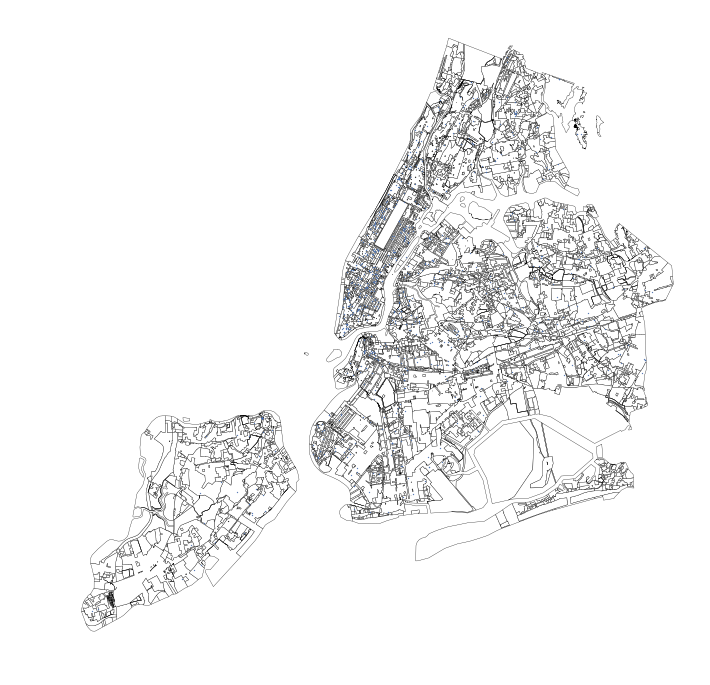

In [173]:
base = nyzd_19.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
complaints19.plot(ax=base,markersize=1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


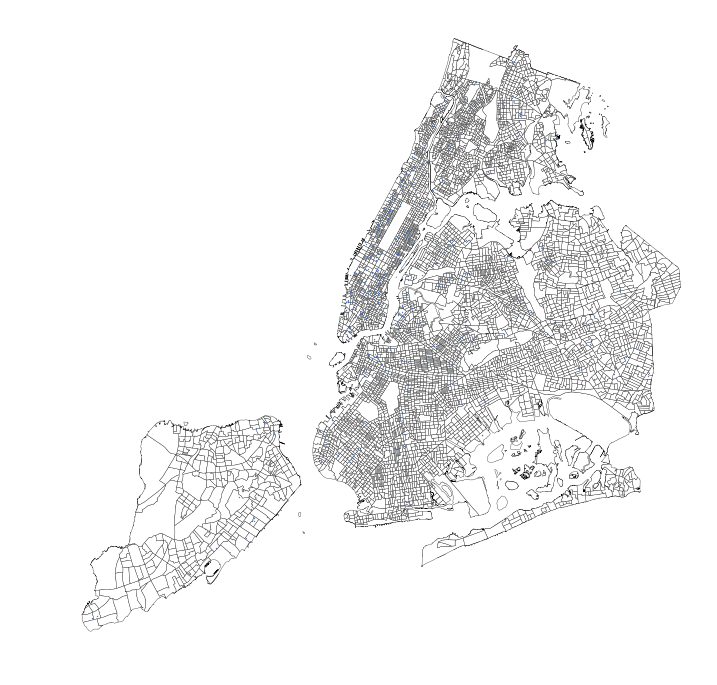

In [174]:
base = census_df_2017.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
complaints19.plot(ax=base,markersize=1)

In [177]:
nyzd_19.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [208]:
complaints19.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'AHV', 'lonlat', 'geometry'],
      dtype='object')

In [209]:
complaints19.dropna(subset=['geometry','Latitude', 'Longitude'],inplace=True)

In [210]:
nyzd_19 = nyzd_19.to_crs(epsg=2263)
df_zoned_19 = gpd.sjoin(complaints19,nyzd_19,how='left')

In [212]:
df_zoned_19.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'AHV', 'lonlat', 'geometry',
       'index_right', 'ZONEDIST', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [213]:
df_zoned_19.drop(['index_right'],axis=1, inplace=True)

In [214]:
df_zoned_census_2019 = gpd.sjoin(df_zoned_19,census_df_2017,how='left')

In [215]:
df_zoned_census_2019.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'AHV', 'lonlat', 'geometry',
       'ZONEDIST', 'Shape_Leng', 'Shape_Area', 'index_right', 'OBJECTID',
       'total_population', 'white_population', 'african_american_popu